## Mnist Dataset Classification using K-Nearest Neighbors (Euclidean)

### Summary
<img align="right" src="../image/NearestNeighbor.png" width=150 height=150>
KNN은 새로운 데이터가 주어졌을 때 기존 데이터 가운데 가장 가까운 k개 이웃의 정보로 새로운 데이터를 예측하는 알고리즘

새로운 데이터가 주어진 경우 기존 모든 데이터와의 거리를 계산한다. 계산된 거리 값이 작은 k개의 데이터를 선정한다. 새로운 데이터의 클래스는 선정된 데이터들의 클래스 중 가장 많이 선택된 클래스로 분류한다.

거리 계산 방법에는 Euclidean, Mahalanobis 등 있다.

CIFAR10 데이터셋을 이용하여 10가지 클래스를 구분한다. 거리 계산 방법은 Euclidean을 사용한다.

Time 측정 방법은 Method 측면에서는 
1. Model Fitting Time : KNN의 경우 데이터셋에 대한 Checking 및 데이터셋 메모리에 카피
2. All Test Data Prediction Time
3. One Instance Prediction Time 10번 평균

PCA 측면에서는 
1. Calculate Train Data SVD Matrix Time
2. Transform Train X to N-PCA Time
3. Transform Test X to N-PCA Time

In [1]:
import time
from tqdm import tqdm
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from torchvision.datasets import CIFAR10

In [2]:
class BaseConfig:
    def __init__(self):
        pass

    def info(self):
        config_list = {
            0 : ['Dataset', self.dataset, 
                 "Train size: " + str(int((1-self.test_size)*100))+"%",
                 'Feature size: ' + str(self.feature_size), 1],
            1 : ['Method', self.method, 
                 "k = " + str(self.k), self.distance, 2],
            2 : ['Dimension reduction', 
                 'Method: ' + str(self.reduction_method[0]),
                 'Component size: ' + str(self.reduction_method[1]),
                 'Feature Reduction Ratio: ' + \
                    str(round(self.reduction_method[1]/self.feature_size, 3)*100 if self.reduction_method[1] is not None else None)+"%", 3],
            3 : ['Iteration', str(self.iter), -1]
        }

        print("Device " + "─" * 2 + " " + self.device)
        print("│")

        parent = 1
        for child in range(len(config_list)):
            for idx, contents in enumerate(config_list[child][:-1]):
                if idx == 0 and child == len(config_list)-1:
                    print("└" + "─" * 2 + contents)
                elif idx == 0:
                    print("├" + "─" * 2 + contents)
                elif child == len(config_list)-1:
                    print(" " * 4 + "└" + "─" * 4 + contents)
                else:
                    print("│" + " " * 4 + "└" + "─" * 4 + contents)
            parent = config_list[child][-1]
            if parent == -1: break
            print("│")

    def print_rutin(self):
        if self.reduction_method[0] is None:
            rutin = str(self.device) + " - " + str(self.dataset) + "(" + str(int((1-self.test_size)*100)) + "%) - " + str(self.method) + " - " + str(self.iter) + " iteration"
            print(rutin)
        else:
            rutin = str(self.device) + " - " + str(self.dataset) + "(" + str(int((1-self.test_size)*100)) + "%) - " + str(self.method) + " - " + str(self.iter) + " iteration - " + str(self.reduction_method[0]) + "(feature " + str(self.reduction_method[1]) + ")"
            print(rutin)

class Config(BaseConfig):
    def __init__(self):
        super(BaseConfig, self).__init__()
        self.device = 'Jetson'
        self.dataset = 'CIFAR10'
        self.test_size = 0.2
        self.feature_size = 32*32*3
        self.method = 'kNN'
        self.k = 1
        self.distance = 'Euclidean'
        self.reduction_method = [None, None] # method, n_components
        self.iter = 10


# Load Mnist Dataset

<a title="cifar10 image" href="https://tutorials.pytorch.kr/_images/cifar10.png"><img width="512" alt="Cifar10Examples" src="https://tutorials.pytorch.kr/_images/cifar10.png"/></a>

In [3]:
download_root = '../../datasets/CIFAR10'

train_dataset = CIFAR10(download_root, train=True, download=False)
test_dataset = CIFAR10(download_root, train=False, download=False)

In [6]:
train_cifar10_X, train_cifar10_y = train_dataset.data, np.array(train_dataset.targets)
test_cifar10_X, test_cifar10_y = test_dataset.data, np.array(test_dataset.targets)

print(f'Train data X shape : {train_cifar10_X.shape}, y shape : {train_cifar10_y.shape}')
print(f'Test data X shape : {test_cifar10_X.shape}, y shape : {test_cifar10_y.shape}')

Train data X shape : (50000, 32, 32, 3), y shape : (50000,)
Test data X shape : (10000, 32, 32, 3), y shape : (10000,)


In [7]:
print(f'Mnist Data range [{train_cifar10_X.min()}, {train_cifar10_X.max()}] ')

train_cifar10_X, test_cifar10_X = train_cifar10_X / 255., test_cifar10_X / 255.

print(f'--> Mnist Data Normalized range [{train_cifar10_X.min()}, {train_cifar10_X.max()}] ')

Mnist Data range [0, 255] 
--> Mnist Data Normalized range [0.0, 1.0] 


## Sample Images

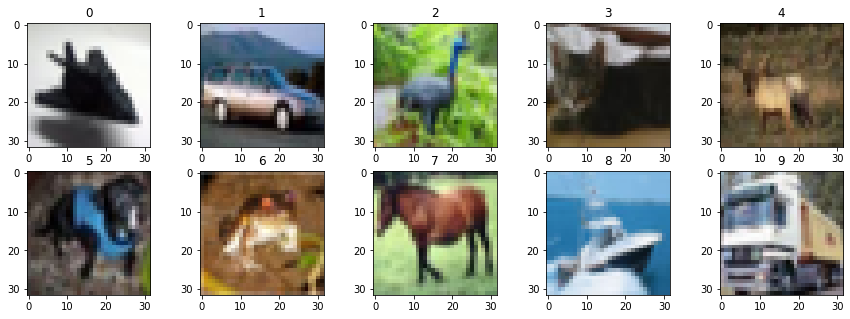

In [8]:
plt.figure(figsize=(15, 5))

for i in range(10):
    sample_idx = np.where(train_cifar10_y == i)[0][0]

    sample_image = train_cifar10_X[sample_idx]
    sample_label = train_cifar10_y[sample_idx]

    plt.subplot(2, 5, i+1) # nrows, ncolumns, index
    plt.title(sample_label)
    plt.imshow(sample_image,'gray')
plt.show()

## Train & Test Data Label Distribution

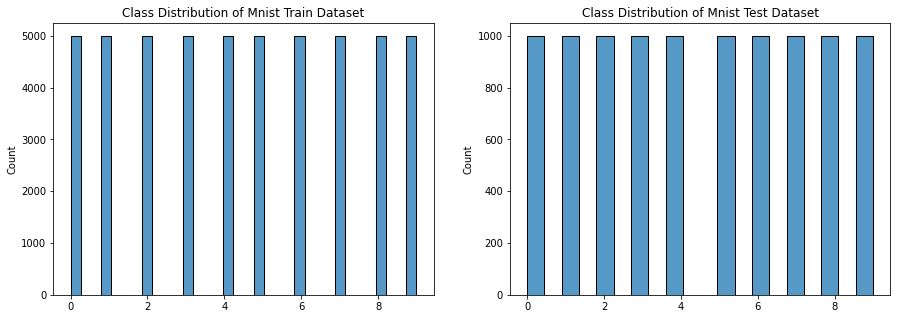

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_cifar10_y, palette="tab10")
plt.title("Class Distribution of Mnist Train Dataset")

plt.subplot(1, 2, 2)
sns.histplot(test_cifar10_y, palette="tab10")
plt.title("Class Distribution of Mnist Test Dataset")
plt.show()

## Preprocessing
 * Flatten 32 x 32 x 3 images to 3072 vectors

In [8]:
print(f'Mnist Data shape train : {train_cifar10_X.shape}, test : {test_cifar10_X.shape}')

train_cifar10_X = train_cifar10_X.reshape(-1, 32*32*3)
test_cifar10_X = test_cifar10_X.reshape(-1, 32*32*3)

print(f'--> Mnist Data shape train : {train_cifar10_X.shape}, test : {test_cifar10_X.shape}')

Mnist Data shape train : (50000, 32, 32, 3), test : (10000, 32, 32, 3)
--> Mnist Data shape train : (50000, 3072), test : (10000, 3072)


## K-Nearest Neighbor

In [11]:
config = Config()
config.info()

Device ── Jetson
│
├──Dataset
│    └────CIFAR10
│    └────Train size: 80%
│    └────Feature size: 3072
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


In [12]:
def knn_run(train_data_X = train_cifar10_X,
            train_data_y = train_cifar10_y,
            test_data_X = test_cifar10_X,
            test_data_y = test_cifar10_y,
            config = None,
            weights = 'distance'):

    assert config is not None
    # config.info()
    config.print_rutin()
    k = config.k
    max_seed = config.iter

    avg_test_acc = []
    avg_knn_fit_time = []
    avg_pred_time = []
    preds = []

    for seed in tqdm(range(max_seed)):
        x_train, x_test, y_train, y_test = train_data_X, test_data_X, train_data_y, test_data_y

        knn = KNeighborsClassifier(n_neighbors=k, weights=weights, n_jobs=-1)

        start_time = time.perf_counter()
        knn.fit(x_train, y_train)
        knn_fit_time = time.perf_counter() - start_time
        avg_knn_fit_time.append(knn_fit_time)

        start_time = time.perf_counter()
        pred = knn.predict(x_test)
        pred_time = time.perf_counter() - start_time
        preds.append(pred)

        test_score = accuracy_score(pred, y_test)
        avg_test_acc.append(test_score)
        avg_pred_time.append(pred_time)

    print("Train size : ", len(x_train), " / Test size : ", len(x_test))
    print("-----" * 8)
    print("Test set score: %f" % np.array(avg_test_acc).mean())
    print("KNN fitting Time: %.4f ± %.5f" % (np.array(avg_knn_fit_time).mean(), np.array(avg_knn_fit_time).std()), "sec")
    print("All Test dataset Prediction Time at once : %.4f ± %.5f" % (np.array(avg_pred_time).mean(), np.array(avg_pred_time).std()), "sec")
    print("Divide the Prediction Time by Test size : %.8f ± %.8f" % (np.array(avg_pred_time).mean()/len(x_test)*1e6, np.array(avg_pred_time).std()/len(x_test)*1e6), "microsec")

    return avg_test_acc, avg_knn_fit_time, avg_pred_time

In [15]:
config.k = 1

# avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_cifar10_X,
#                                                         train_data_y = train_cifar10_y,
#                                                         test_data_X = test_cifar10_X,
#                                                         test_data_y = test_cifar10_y,
#                                                         config = config,
#                                                         weights = 'distance')

In [16]:
config.k = 2

# avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_cifar10_X,
#                                                         train_data_y = train_cifar10_y,
#                                                         test_data_X = test_cifar10_X,
#                                                         test_data_y = test_cifar10_y,
#                                                         config = config,
#                                                         weights = 'distance')

In [17]:
config.k = 3

# avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_cifar10_X,
#                                                         train_data_y = train_cifar10_y,
#                                                         test_data_X = test_cifar10_X,
#                                                         test_data_y = test_cifar10_y,
#                                                         config = config,
#                                                         weights = 'distance')

### 1개의 Instance를 예측하는데 걸리는 시간 측정 - 10번 반복

In [19]:
def knn_run_one_instance(train_data_X = train_cifar10_X,
            train_data_y = train_cifar10_y,
            test_data_X = test_cifar10_X,
            test_data_y = test_cifar10_y,
            config = None,
            weights = 'distance'):

    assert config is not None
    # config.info()
    config.print_rutin()
    k = config.k
    max_seed = config.iter


    x_train, x_test, y_train, y_test = train_data_X, test_data_X, train_data_y, test_data_y

    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)

    start_time = time.perf_counter()
    knn.fit(x_train, y_train)
    knn_fit_time = time.perf_counter() - start_time

    avg_test_acc = []
    avg_pred_time = []
    preds = []
    ys_test = []
    count = 0

    for x_one, y_one in tqdm(zip(x_test, y_test)):
        x_one = x_one.reshape(1, -1)

        start = time.perf_counter()
        pred = knn.predict(x_one)
        pred_time = time.perf_counter() - start
        

        avg_pred_time.append(pred_time)
        preds.append(pred)
        ys_test.append(y_one)

        count += 1
        if count == 10:
            break

    test_score = accuracy_score(preds, ys_test)
    avg_test_acc.append(test_score)
    avg_pred_time.append(pred_time)

    print("Train size : ", len(x_train), " / Test size : ", 10)
    print("-----" * 8)
    print("Test set score: %f" % np.array(avg_test_acc).mean())
    print("KNN fitting Time: %.4f" % (knn_fit_time), "sec")
    print("One Instance Prediction Average Time : %.8f ± %.8f" % (np.array(avg_pred_time).mean(), np.array(avg_pred_time).std()), "sec")

    return avg_test_acc, knn_fit_time, avg_pred_time

In [20]:
config.k = 1

avg_test_acc, knn_fit_time, avg_pred_time = knn_run_one_instance(train_data_X = train_cifar10_X,
                                                        train_data_y = train_cifar10_y,
                                                        test_data_X = test_cifar10_X,
                                                        test_data_y = test_cifar10_y,
                                                        config = config,
                                                        weights = 'distance')

Jetson - CIFAR10(80%) - kNN - 10 iteration


9it [05:58, 39.85s/it] 


Train size :  50000  / Test size :  10
----------------------------------------
Test set score: 0.400000
KNN fitting Time: 57.7746 sec
One Instance Prediction Average Time : 32.60104625 ± 85.94254977 sec


In [21]:
config.k = 2

# avg_test_acc, knn_fit_time, avg_pred_time = knn_run_one_instance(train_data_X = train_cifar10_X,
#                                                         train_data_y = train_cifar10_y,
#                                                         test_data_X = test_cifar10_X,
#                                                         test_data_y = test_cifar10_y,
#                                                         config = config,
#                                                         weights = 'distance')

In [22]:
config.k = 3

# avg_test_acc, knn_fit_time, avg_pred_time = knn_run_one_instance(train_data_X = train_cifar10_X,
#                                                         train_data_y = train_cifar10_y,
#                                                         test_data_X = test_cifar10_X,
#                                                         test_data_y = test_cifar10_y,
#                                                         config = config,
#                                                         weights = 'distance')

In [23]:
n_components_list = []
pca_fit_time_list = []
train_features_extract_time_list = []
test_features_extract_time_list = []

### kNN with PCA feature 2

### Time of calculating PCA

In [24]:
def pca_run(train_data_X = train_cifar10_X,
            test_data_X = test_cifar10_X,
            config=None):

    assert config is not None
    config.info()

    n_components = config.reduction_method[1]

    pca_dims = PCA(n_components)
    print(f"The number of components : {n_components}")

    start_time = time.perf_counter()
    pca_dims.fit(train_data_X)
    pca_fit_time = time.perf_counter () - start_time
    print()
    print(f"Calculating SVD Matrix Time on Train Data-{train_data_X.shape} : {pca_fit_time:4f} sec")
    
    start_time = time.perf_counter()
    train_features = pca_dims.transform(train_data_X)
    train_features_extract_time = time.perf_counter () - start_time
    print(f"Transform train X-{train_data_X.shape} to {n_components}-PCA Time: {train_features_extract_time:4f} sec")

    start_time = time.perf_counter()
    test_features = pca_dims.transform(test_data_X)
    test_features_extract_time = time.perf_counter () - start_time
    print(f"Transform test X-{test_data_X.shape} to {n_components}-PCA Time: {test_features_extract_time:4f} sec")

    return pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time
    

In [26]:
config.reduction_method = ['PCA', 2]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_cifar10_X,
            test_data_X = test_cifar10_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── Jetson
│
├──Dataset
│    └────CIFAR10
│    └────Train size: 80%
│    └────Feature size: 3072
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 2
│    └────Feature Reduction Ratio: 0.1%
│
└──Iteration
    └────10
The number of components : 2

Calculating SVD Matrix Time on Train Data-(50000, 3072) : 318.064569 sec
Transform train X-(50000, 3072) to 2-PCA Time: 113.084249 sec
Transform test X-(10000, 3072) to 2-PCA Time: 11.668048 sec


In [27]:
config.k = 2

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_cifar10_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_cifar10_y,
                                                        config = config,
                                                        weights = 'distance')

Jetson - CIFAR10(80%) - kNN - 10 iteration - PCA(feature 2)


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

Train size :  50000  / Test size :  10000
----------------------------------------
Test set score: 0.146600
KNN fitting Time: 0.1585 ± 0.19005 sec
All Test dataset Prediction Time at once : 0.1530 ± 0.05373 sec
Divide the Prediction Time by Test size : 15.29732147 ± 5.37261810 microsec


### kNN with PCA feature 3

In [28]:
config.reduction_method = ['PCA', 3]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_cifar10_X,
            test_data_X = test_cifar10_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── Jetson
│
├──Dataset
│    └────CIFAR10
│    └────Train size: 80%
│    └────Feature size: 3072
│
├──Method
│    └────kNN
│    └────k = 2
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 3
│    └────Feature Reduction Ratio: 0.1%
│
└──Iteration
    └────10
The number of components : 3

Calculating SVD Matrix Time on Train Data-(50000, 3072) : 375.775921 sec
Transform train X-(50000, 3072) to 3-PCA Time: 100.215960 sec
Transform test X-(10000, 3072) to 3-PCA Time: 13.775327 sec


In [29]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_cifar10_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_cifar10_y,
                                                        config = config,
                                                        weights = 'distance')

Jetson - CIFAR10(80%) - kNN - 10 iteration - PCA(feature 3)


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

Train size :  50000  / Test size :  10000
----------------------------------------
Test set score: 0.174700
KNN fitting Time: 0.1273 ± 0.08178 sec
All Test dataset Prediction Time at once : 0.2105 ± 0.10031 sec
Divide the Prediction Time by Test size : 21.04905422 ± 10.03091942 microsec


### kNN with PCA feature 4

In [30]:
config.reduction_method = ['PCA', 4]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_cifar10_X,
            test_data_X = test_cifar10_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── Jetson
│
├──Dataset
│    └────CIFAR10
│    └────Train size: 80%
│    └────Feature size: 3072
│
├──Method
│    └────kNN
│    └────k = 3
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 4
│    └────Feature Reduction Ratio: 0.1%
│
└──Iteration
    └────10
The number of components : 4

Calculating SVD Matrix Time on Train Data-(50000, 3072) : 472.995437 sec
Transform train X-(50000, 3072) to 4-PCA Time: 107.460708 sec
Transform test X-(10000, 3072) to 4-PCA Time: 12.052159 sec


In [31]:
config.k = 4

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_cifar10_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_cifar10_y,
                                                        config = config,
                                                        weights = 'distance')

Jetson - CIFAR10(80%) - kNN - 10 iteration - PCA(feature 4)


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

Train size :  50000  / Test size :  10000
----------------------------------------
Test set score: 0.197700
KNN fitting Time: 0.1447 ± 0.11482 sec
All Test dataset Prediction Time at once : 0.3785 ± 0.09600 sec
Divide the Prediction Time by Test size : 37.85086176 ± 9.59952377 microsec


### kNN with PCA feature 5

In [25]:
config.reduction_method = ['PCA', 5]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_cifar10_X,
            test_data_X = test_cifar10_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── Jetson
│
├──Dataset
│    └────CIFAR10
│    └────Train size: 80%
│    └────Feature size: 3072
│
├──Method
│    └────kNN
│    └────k = 3
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 5
│    └────Feature Reduction Ratio: 0.2%
│
└──Iteration
    └────10
The number of components : 5

Calculating SVD Matrix Time on Train Data-(50000, 3072) : 357.472431 sec
Transform train X-(50000, 3072) to 5-PCA Time: 115.823265 sec
Transform test X-(10000, 3072) to 5-PCA Time: 5.807293 sec


In [26]:
config.k = 5

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_cifar10_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_cifar10_y,
                                                        config = config,
                                                        weights = 'distance')

Jetson - CIFAR10(80%) - kNN - 10 iteration - PCA(feature 5)


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

Train size :  50000  / Test size :  10000
----------------------------------------
Test set score: 0.243800
KNN fitting Time: 0.1074 ± 0.06902 sec
All Test dataset Prediction Time at once : 0.3982 ± 0.08629 sec
Divide the Prediction Time by Test size : 39.82480969 ± 8.62854753 microsec


### kNN with PCA feature that explain 70% original data

In [77]:
pca = PCA(n_components=0.7)
pca_trans = pca.fit(train_cifar10_X).transform(train_cifar10_X)

print(pca_trans.shape)

(50000, 15)


In [27]:
config.reduction_method = ['PCA', 15]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_cifar10_X,
            test_data_X = test_cifar10_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── Jetson
│
├──Dataset
│    └────CIFAR10
│    └────Train size: 80%
│    └────Feature size: 3072
│
├──Method
│    └────kNN
│    └────k = 5
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 15
│    └────Feature Reduction Ratio: 0.5%
│
└──Iteration
    └────10
The number of components : 15


In [ ]:
config.k = 15

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_cifar10_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_cifar10_y,
                                                        config = config,
                                                        weights = 'distance')

### kNN with PCA feature that explain 80% original data

In [78]:
pca = PCA(n_components=0.8)
pca_trans = pca.fit(train_cifar10_X).transform(train_cifar10_X)

print(pca_trans.shape)

(50000, 33)


In [ ]:
config.reduction_method = ['PCA', 33]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_cifar10_X,
            test_data_X = test_cifar10_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

In [ ]:
config.k = 33

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_cifar10_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_cifar10_y,
                                                        config = config,
                                                        weights = 'distance')

### kNN with PCA feature that explain 90% original data

In [90]:
pca = PCA(n_components=0.9)
pca_trans = pca.fit(train_cifar10_X).transform(train_cifar10_X)

print(pca_trans.shape)

(50000, 99)


In [ ]:
config.reduction_method = ['PCA', 99]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_cifar10_X,
            test_data_X = test_cifar10_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

In [ ]:
config.k = 99

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_cifar10_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_cifar10_y,
                                                        config = config,
                                                        weights = 'distance')

In [ ]:
config.k = 3

avg_test_acc, avg_knn_fit_time, avg_pred_time = knn_run(train_data_X = train_features,
                                                        train_data_y = train_cifar10_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_cifar10_y,
                                                        config = config,
                                                        weights = 'distance')

### Three part time of PCA

In [ ]:
plt.figure()
plt.plot(pca_fit_time_list, "b", label="Train SVD Matrix Time")
plt.legend()
plt.plot(train_features_extract_time_list, "r", label="Train PCA Time")
plt.plot(test_features_extract_time_list, "g", label="Test PCA Time")
plt.legend()
plt.title("PCA Time Comparison")
plt.show()